# The Mass-Load Boundary Condition

*contact: Alexander Renz, mike.de@dhigroup.com*

**Accurately Specifying Solute Concentrations at Inflowing Boundary Conditions**

Some modelling aplications require an inflow of water with a specified non-zero solute 
concentration.

Examples are
+ injection wells,
+ tailings seepage,
+ salt concentrations in recharge originating from surf spray,
+ infiltration from lakes and reservoirs, rivers or oceans.

The specification of both water inflow and mass inflow (dispersive + advective) at the
same location is necessary. Dirichlet-type BC (allows specification of advective influx, 
not dispersive influx) and Neumann-type BC (allows specification of dispersive influx, 
not advective influx) are not suitable for this task when using the default Convective 
Form of Transport.

While using the Divergence Form of Transport does allow specifying the total mass inflow 
and therefore the inflowing concentration directly, this settings has other implications
that complicates the model setup in many cases and its usage is usually avoided.

This document shows that it is possible to specify total mass flux and hence inflowing 
concentration **by using a Cauchy-Type boundary condition with**

+ **reference concentration equal to the inflowing solute concentration**
+ **mass-transfer rate equal to the normal Darcy velocity at the inflowing border.**

## Derivation

The formulation of the inflowing mass transport boundary condition is the scope of
this study.

The objective is to find a boundary condition
formulation that ensures that the total mass influx
(dispersive influx + advective influx) is equal
to the required value.

$$Q_{tot} = Q_{adv} + Q_{disp} = F  \cdot C_{in}$$

With 

+ $Q_{tot}$ total mass flux
+ $Q_{adv}$ advective part of mass flux
+ $Q_{disp}$ dispersive/diffuse part of mass flux
+ fluid flow rate $F$ 
+ inflowing concentration $C_{in}$.

The advective influx $Q_{adv}$ is the product of fluid
inflow $F$ and local concentration $C$ (concentration at
the node where the boundary condition is applied).

$$Q_{adv} = C \cdot F$$

It follows that

$$Q_{disp}  = Q_{tot} – Q_{adv} \\
Q_{disp}    = F \cdot C_{in} – F \cdot C \\
Q_{disp}    = F (C_{in} – C)$$

A Cauchy-type mass transport boundary condition, using $C_{in}$ as reference
concentration value $C_{Cauchy}$ and Flow rate $F$ equal to the Transfer-rate 
$\phi$ corresponds to this formulation:

$$Qdisp = Phi \cdot (C_{Ref} – C)\\
= F \cdot (C_{in} – C)$$

with 
+ $F = \phi$
+ $C_{Ref} = C_{in}$

Consequently, it is possible to use a Mass-Transfer BC at an inflowing border to 
specify the concentration of the inflowing water.

## Example - Specifying Mass Load at known Inflow Rate

### Specifying concentration at inflowing Fluid-Flux BC

#### 2D Benchmark model

To test this approach a representative 2D
cross-sectional model is used. The injection
of saltwater is located at the top surface.
Figure 1 shows the general setup of the
boundary conditions.

A fluid-flux BC is used to infiltrate water with
a specified darcy flux. The water can leave
the model at its lateral borders through
Hydraulic head boundary conditions. By
choosing different vaues at the left and right
borders a lateral flow can be imposed.

Inflowing water at the left border is specified
as C = 0 (Freshwater). The convective form
of transport allows a free outflow from the
model at outflowing borders.

**Injection without lateral flow**

With equal hydraulic head at the left and
right border, the model is run with different
settings for F, Phi and CSW.

Because the concentration in the model
increases from initially freshwater to CSW in
final equilibrium conditions, the ratio
between advective and dispersive flux
changed during the model run (only
dispersive at the beginning, only advective in
the end). The total flux however was
maintained at all times, the budgeted mass
inflow matched the conceptual value.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ["FEFLOW_KERNEL_VERSION"]="74"
import ifm_contrib as ifm
ifm.getKernelVersion()

7402

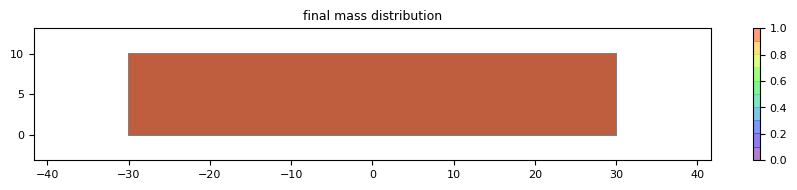

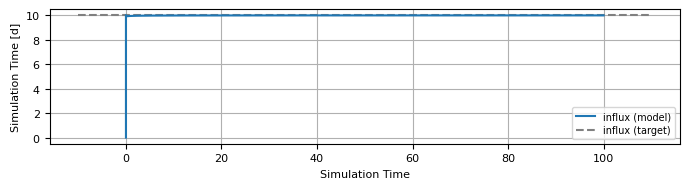

In [2]:
doc = ifm.loadDocument("./mass-load-boundary-condition/femdata/Qtot_1md.fem")
doc.startSimulator()

plt.style.use("DHI")

fig, ax1 = plt.subplots(1, figsize=(9, 2))
doc.c.plot.faces()
doc.c.plot.fringes(par=ifm.Enum.P_CONC, levels=np.arange(0,1.1,0.1))
ax1 = plt.gca()
ax1.axis("equal")
plt.title("final mass distribution")
plt.colorbar(format='%.1f')
plt.show()

fig, ax1 = plt.subplots(1, figsize=(7, 2))

doc.c.hist.df.history(ifm.Enum.HIST_MFLUX).inflow.plot(label="influx (model)")
plt.hlines([10], -10, 110, color="grey", linestyle="--", label="influx (target)")
ax1.set_ylabel("Mass Rate Budget [g/d]")
ax1.set_ylabel("Simulation Time [d]")
plt.legend()
plt.grid()
plt.show()

**Injection with lateral flow**

To test the influence of lateral inflow, a
strong fluid flow was imposed from the left to
the right using different head values for the
left anright boundary conditions. Water
enters the domain from the left as
freshwater.
The result shows that also under these
conditions the correct influx is maintained.

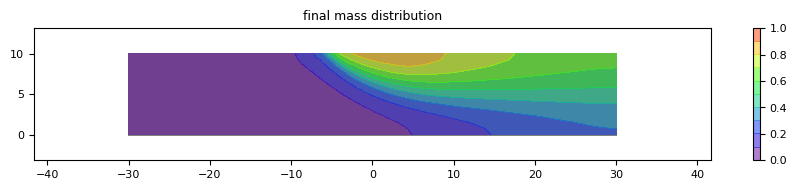

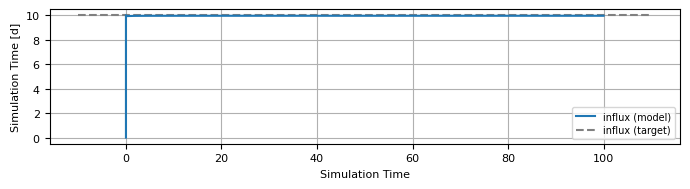

In [3]:
doc = ifm.loadDocument("./mass-load-boundary-condition/femdata/Qtot_1md_lateralFlow.fem")
doc.startSimulator()

plt.style.use("DHI")

fig, ax1 = plt.subplots(1, figsize=(9, 2))
doc.c.plot.faces()
doc.c.plot.fringes(par=ifm.Enum.P_CONC, levels=np.arange(0,1.1,0.1))
ax1 = plt.gca()
ax1.axis("equal")
plt.title("final mass distribution")
plt.colorbar()
plt.show()

fig, ax1 = plt.subplots(1, figsize=(7, 2))

doc.c.hist.df.history(ifm.Enum.HIST_MFLUX).inflow.plot(label="influx (model)")
plt.hlines([10], -10, 110, color="grey", linestyle="--", label="influx (target)")

ax1.set_ylabel("Mass Rate Budget [g/d]")
ax1.set_ylabel("Simulation Time [d]")
plt.legend()
plt.grid()
plt.show()

In [4]:
doc.closeDocument()

## Example - Specifying Mass Load on Fluid Flow Calculated at Runtime

The case is more complex if the inflow rate is not known before running the model, typically when a Dirichlet or Cauchy flow BC is involved.

In this case, the transfer rate of the Cauchy type Mass-Transfer BC must be updated at simulation runtime.
This is done using a Python Script embedded in the FEFLOW model.


### Specifying concentrations at inflowing Fluid-Transfer BC

The example model represents an infiltrating surface water body (Fluid-Transfer BC) with a non-zero solute concentration.
Both the water level and the solute concentration changes over time.

In [5]:
doc = ifm.loadDocument("./mass-load-boundary-condition/femdata/nodal_transfer_bc_3D_transient_solute_3rd.fem")

In [6]:
df_href = doc.c.ts.df.points("river_level")
df_conc = doc.c.ts.df.points("river_conc")

Text(0, 0.5, 'concentration [g/m³]')

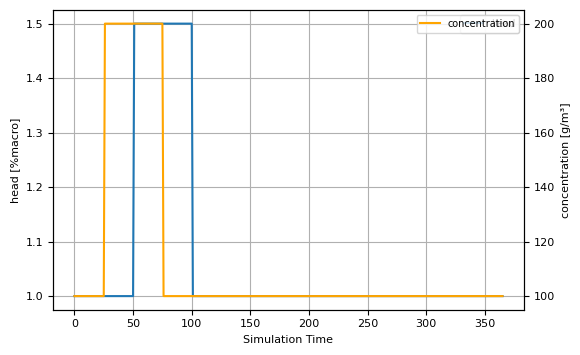

In [7]:
plt.style.use("DHI")
ax1=plt.gca()
ax1b=ax1.twinx()
df_href.Values.plot(ax=ax1, label="head")
df_conc.Values.plot(ax=ax1b, label="concentration", color="orange")
ax1.grid()
ax1b.legend()
ax1.legend()
ax1.set_ylabel("head [%macro]")
ax1b.set_ylabel("concentration [g/m³]")

**Dirichlet Mass-Conc BC overestimates Influx**

The resulting effective infiltration rate at this boundary condition is small compared to the lateral flow movement of the water, 
and applying a Dirichlet-Type Mass-Concentration BC will overestimate dispersive mass influx and therefore total mass influx into the system.

This will be demonstrated first: In the following model run, a Dirichlet boundary condition is applied with inflowing nodes.

The upper chart of the plot below show the resulting rates for flow and mass flux, respectively.

The concentration of the inflowing water is determined by dividing the mass flux rate by the flow rate, which does not match the expected setup.

In [8]:
doc.startSimulator()

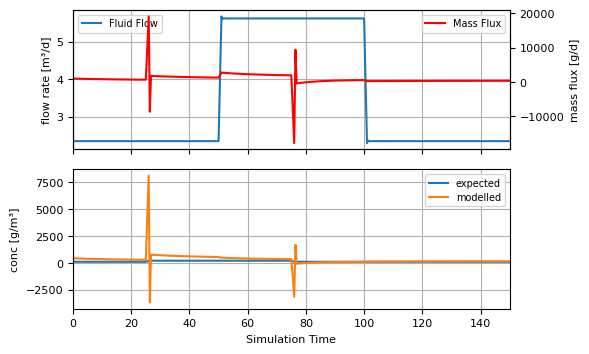

In [9]:
plt.style.use("DHI")

# show results - flow rate and mass flux
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
doc.c.hist.df.FFLUX.river.plot(ax=ax1, label="Fluid Flow")
ax1.set_ylabel("flow rate [m³/d]")
ax1b = ax1.twinx()
doc.c.hist.df.MFLUX.river.plot(ax=ax1b, label="Mass Flux", color="red")
ax1b.set_ylabel("mass flux [g/d]")
ax1.grid()
ax1.legend(loc="upper left")
ax1b.legend()

# show expeceted and modelled concentration
df_inflow_conc = doc.c.hist.df.MFLUX / doc.c.hist.df.FFLUX
ax2.set_ylabel("conc [g/m³]")
doc.c.ts.df.points("river_conc").Values.plot(ax=ax2, label="expected")
df_inflow_conc.river.plot(ax=ax2, label="modelled")
ax2.grid()
ax2.set_xlim(0, 150)
ax2.legend()

In [10]:
doc.closeDocument()

**Using the mass load BC**

We will now deploy the mass load BC again.

This case is more complex as the inwards Darcy-Flux is not known a-priori and needs to be determined at model run-time.
This is currently only possible using the Python IFM API:

+ After the flow simulation, the nodal budget at each inflowing node is calculated
+ The nodal budget is used as the mass-transfer rate of a **nodal** mass-transfer BC
+ The inflowing concentration is specified as the reference head of a nodal mass-transfer BC

Note that the nodal mass-transfer BC is choosen as it is more accurate to determine nodal fluxes through the budget than
calculating normal darcy velocities for a default areal mass-transfer BC. Also note that this type of boundary condition
can be created exclusively via the IFM API.

The script reads the reference (inflowing) concentration from a Dirichlet boundary conditions.
For easier usage, the model contains a second species solely for the purpose of specifying the concentration BC.
The species is set to solid-face option, thus that it does not take part in the transport equation to save computational time.

As can be seen from this benchmark, this approach delivers an almost accurate representation of the inflowing concentration.

In [11]:
# now again with nodal transfer BC

In [12]:
doc = ifm.loadDocument("./mass-load-boundary-condition/femdata/nodal_transfer_bc_3D_transient_solute_3rd.fem")

In [13]:
# get node indices
nodes = doc.getSelectionItems(ifm.Enum.SEL_NODES, doc.findSelection(ifm.Enum.SEL_NODES, "river"))

doc.setMultiSpeciesId(1)
cref_values = [doc.getBcMassValue(n) for n in nodes]
doc.setMultiSpeciesId(0)

In [14]:
### PASTE THIS CODE CELL INTO THE SCRIPTING MENU OF FEFLOW TO RUN THIS CODE INSIDE THE GUI

# get node indices
nodes = doc.getSelectionItems(ifm.Enum.SEL_NODES, doc.findSelection(ifm.Enum.SEL_NODES, "river"))

# get reference concentrations from conc-BC nodes
cref_values = [doc.getBcMassValue(n) for n in nodes]

def postFlowSimulation(doc, phase=0):

    # get nodal flow rates
    bdget = doc.budgetComputeNodal(ifm.Enum.PCLS_FLOW, nodes, True)
    phi_values = bdget.getNodalValues()
    
    # read reference values from other species
    doc.setMultiSpeciesId(1)
    cref_values = [doc.getBcMassValue(n) for n in nodes]   

    # set as nodal values
    doc.setMultiSpeciesId(0)
    doc.setCoupledMassTransBndNodes(nodes, cref_values, phi_values)

In [15]:
doc.startSimulator()

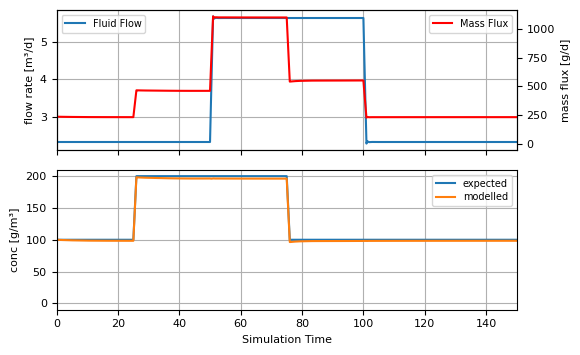

In [16]:
plt.style.use("DHI")

# show results - flow rate and mass flux
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
doc.c.hist.df.FFLUX.river.plot(ax=ax1, label="Fluid Flow")
ax1.set_ylabel("flow rate [m³/d]")
ax1b = ax1.twinx()
doc.c.hist.df.MFLUX.river.plot(ax=ax1b, label="Mass Flux", color="red")
ax1b.set_ylabel("mass flux [g/d]")
ax1.grid()
ax1.legend(loc="upper left")
ax1b.legend()

# show expeceted and modelled concentration
df_inflow_conc = doc.c.hist.df.MFLUX / doc.c.hist.df.FFLUX
ax2.set_ylabel("conc [g/m³]")
doc.c.ts.df.points("river_conc").Values.plot(ax=ax2, label="expected")
df_inflow_conc.river.plot(ax=ax2, label="modelled")
ax2.grid()
ax2.set_xlim(0, 150)
ax2.legend()